# Yelp Review Rating Prediction

Author: Zefang Liu

Github: https://github.com/zefang-liu

## Introduction

In this project, we will predict ratings for Yelp reviews. Google Colab is used here with GPU and High-RAM.

## Data

We will use [Yelp Open Dataset](https://www.yelp.com/dataset). The datasets should be in `Yelp/yelp_dataset` folder.

### Data Preparation

We need to import several packages first.

In [1]:
!nvidia-smi

Thu Nov 24 17:49:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8     3W /  N/A |    496MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content/drive/MyDrive/Yelp

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Yelp'
C:\Users\HP WORLD ANAND\Data Mining\Masters


In [3]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

In [4]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\HP WORLD
[nltk_data]     ANAND\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP WORLD
[nltk_data]     ANAND\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\HP WORLD
[nltk_data]     ANAND\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Here are some file paths.

In [5]:
dir_dataset = "yelp_dataset"
file_business = "./yelp_academic_dataset_business.json"
file_review = "./yelp_academic_dataset_review.json"

We will only use the reviews for restaurants.

In [6]:
def get_restaurants(file_business):
  with open(file_business, 'r',encoding="utf-8") as file:
    restaurants = set()

    for json_str in file:
      obj = json.loads(json_str)
      if obj["business_id"] and obj["categories"] \
      and "restaurants" in obj["categories"].lower():
        restaurants.add(obj["business_id"])

    return restaurants

In [7]:
%time restaurants = get_restaurants(file_business)

Wall time: 1.6 s


In [8]:
print("Number of restaurants:", len(restaurants))

Number of restaurants: 52268


In [9]:
def get_reviews(file_review):
  with open(file_review, 'r',encoding="utf-8") as file:
    text_list = []
    stars_list = []

    for index, json_str in enumerate(file):
      obj = json.loads(json_str)
      if obj["business_id"] and obj["business_id"] in restaurants:
        if obj["text"] and obj["stars"]:
          text_list.append(obj["text"])
          stars_list.append(int(obj["stars"]))

    df = pd.DataFrame.from_dict({"text": text_list, "stars": stars_list})
    return df

In [10]:
%time df_review = get_reviews(file_review)

Wall time: 47 s


In [11]:
df_review.shape

(4724471, 2)

Some samples for reviews.

In [12]:
df_review.head(10)

,text,stars
0,"If you decide to eat here, just be aware it is...",3
1,Family diner. Had the buffet. Eclectic assortm...,3
2,"Wow! Yummy, different, delicious. Our favo...",5
3,Cute interior and owner (?) gave us tour of up...,4
4,I am a long term frequent customer of this est...,1
5,Amazingly amazing wings and homemade bleu chee...,5
6,Had a party of 6 here for hibachi. Our waitres...,3
7,"Locals recommended Milktooth, and it's an amaz...",4
8,Love going here for happy hour or dinner! Gre...,4
9,Good food--loved the gnocchi with marinara\nth...,4


### Data Distribution

We should rating distribution here.

In [13]:
df_review["stars"].value_counts(normalize=False)

5    2079441
4    1130251
1     567185
3     543108
2     404486
Name: stars, dtype: int64

In [14]:
def plot_labels(df, title=None):
  ds_labels = df["stars"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

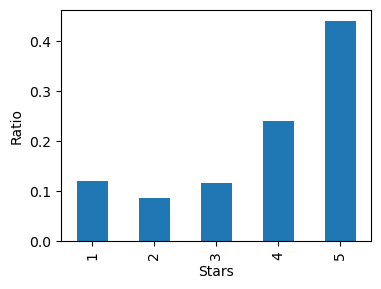

In [15]:
plot_labels(df_review, "stars")

We can find that the dataset is imbalanced.

### Data Preprocessing and Split

We need to seperate training, validation, and testing sets.

* Training set: balanced dataset
* Validation/Testing set: raw (imbalanced) dataset

In [16]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=250000, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=250000,
                                        random_state=42, shuffle=True)

In [17]:
df_train_raw["stars"].value_counts(normalize=False)

5    1859872
4    1010555
1     506702
3     485806
2     361536
Name: stars, dtype: int64

In [18]:
from sklearn.utils import resample

def undersample(df, group_size=250000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group, 
                                     replace=False, 
                                     n_samples=group_size, 
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [19]:
df_train = undersample(df_train_raw)

In [20]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(1250000, 2)


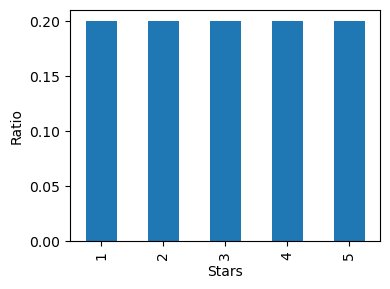

In [21]:
print(df_train.shape)
plot_labels(df_train)

(250000, 2)


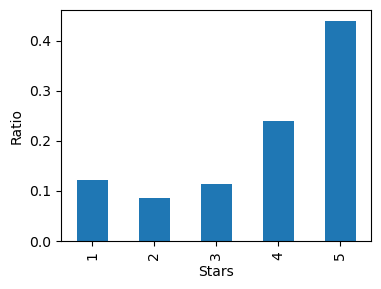

In [22]:
print(df_dev.shape)
plot_labels(df_dev)

(250000, 2)


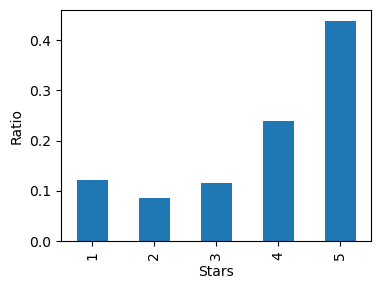

In [23]:
print(df_test.shape)
plot_labels(df_test)

In [24]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

In [25]:
df_train.head(10)

,text,stars,labels
750261,We ordered from Greek Lady after a movie at th...,3,2
4628989,Stopped by this place on a whim searching for ...,3,2
1524775,"The three cup chicken, crystal wontons in chil...",4,3
272617,Outstanding in all respects - and our server K...,5,4
4231423,"This place is one of very few Asian markets, a...",2,1
826087,"This review is for a dinner take out order, ex...",1,0
3940772,My friend and I came last night for happy hour...,2,1
2827184,"Great atmosphere, food was awesome. New drink...",5,4
4246400,This place is flat rerrible. They manage to ru...,1,0
3905298,Seems to be closed!!!!! Today 16th May 2018\n\...,5,4


## Feature Engineering

### Tokenization

In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [26]:
from nltk.tokenize import word_tokenize

In [27]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())
print(df_train["text"].iloc[0], '\n', ds_temp.iloc[0])

We ordered from Greek Lady after a movie at the Bridge one night. The chicken gyro platter was good, with the sides of garlicky potatoes and fries. I dint like the cheesecake that much...dont know bout the ambience though it looks crowded whenever we pass by. 
 ['We', 'ordered', 'from', 'Greek', 'Lady', 'after', 'a', 'movie', 'at', 'the', 'Bridge', 'one', 'night', 'The', 'chicken', 'gyro', 'platter', 'was', 'good', 'with', 'the', 'sides', 'of', 'garlicky', 'potatoes', 'and', 'fries', 'I', 'dint', 'like', 'the', 'cheesecake', 'that', 'much', 'dont', 'know', 'bout', 'the', 'ambience', 'though', 'it', 'looks', 'crowded', 'whenever', 'we', 'pass', 'by']


In [28]:
%time df_train["tokens"] = df_train["text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

Wall time: 35.2 s


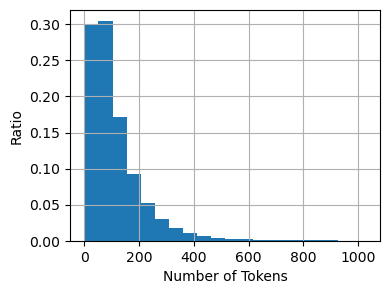

In [29]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [30]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.7045616
0.9214008


In [31]:
df_train.drop(columns=["tokens", "num_tokens"], inplace=True)

In [32]:
%time df_review["num_tokens"] = df_review["text"].\
map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).\
map(lambda text: len(text.split()))

Wall time: 1min


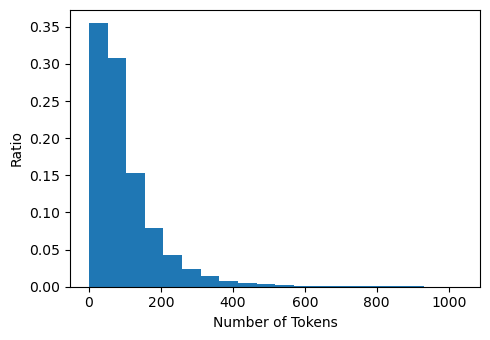

In [33]:
ax = df_review["num_tokens"].hist(bins=20,
                                  figsize=(5,3.5),
                                  grid=False,
                                  weights=np.ones(num_review)/num_review)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.savefig("num_tokens.eps")
plt.tight_layout()
plt.show()

In [34]:
print(len(df_review[df_review["num_tokens"] <= 128]) / len(df_review["num_tokens"]))
print(len(df_review[df_review["num_tokens"] <= 256]) / len(df_review["num_tokens"]))

0.7493245275502802
0.9374025155408934


In [35]:
df_review.drop(columns=["num_tokens"], inplace=True)

From the result, we can see most reviews are shorter than 256 tokens.

### Vectorization

We will try following settings for vectorization.

* Word representation: `CountVectorizer` vs. `TfidfVectorizer`
* N-grams: unigram & bigram
* Minimum document frequency: 5
* Convert to lowercase
* Use stop words
* Try binary counter

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["text"])
  X_dev = vectorizer.transform(df_dev["text"])
  X_test = vectorizer.transform(df_test["text"])
  y_train = df_train["stars"].tolist()
  y_dev = df_dev["stars"].tolist()
  y_test = df_test["stars"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

In [43]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

Wall time: 3min 39s


#### Test for CountVectorizer (Binary)

In [44]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [45]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.4min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


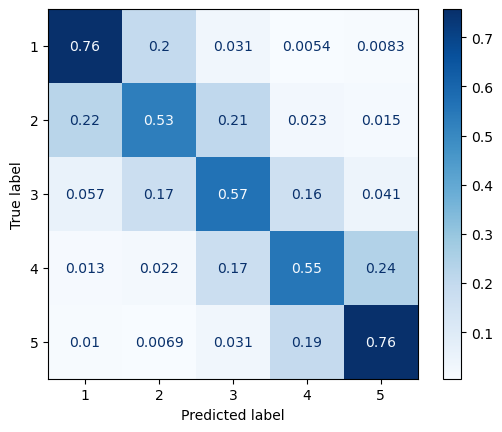


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


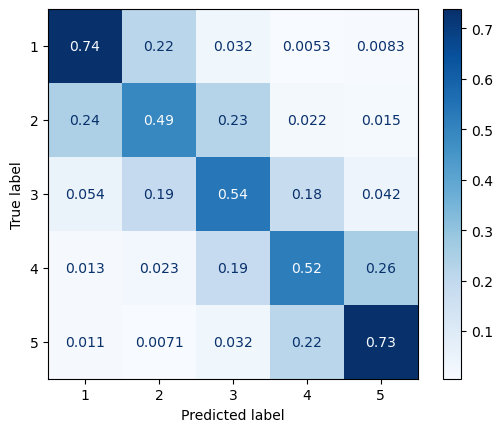


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


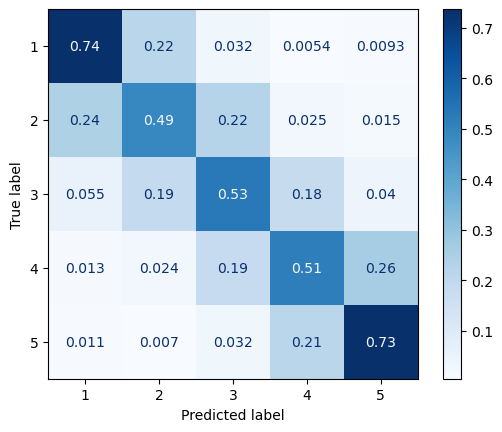

In [46]:
evaluate_model(clf_lr, model_name="lr")

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


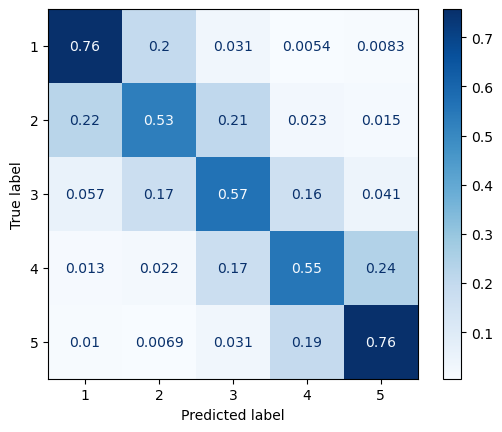


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


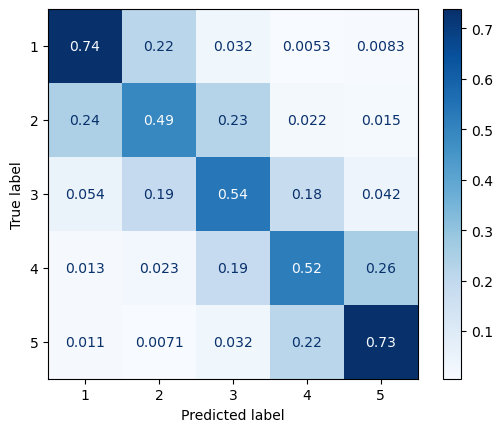


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


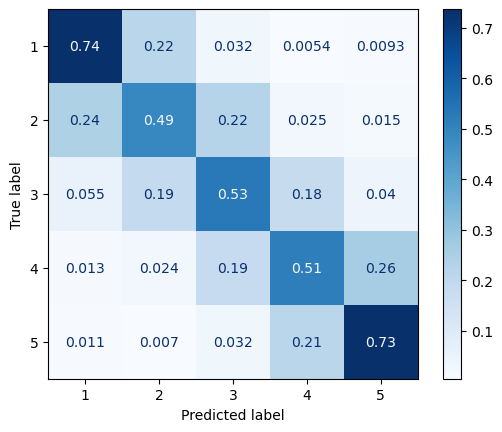

In [47]:
evaluate_model(clf_lr, model_name="lr_count_bin")

#### Test for CountVectorizer (Integer)

In [48]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [49]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.4min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


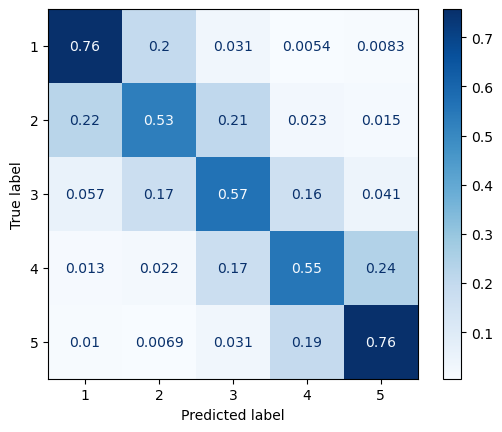


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


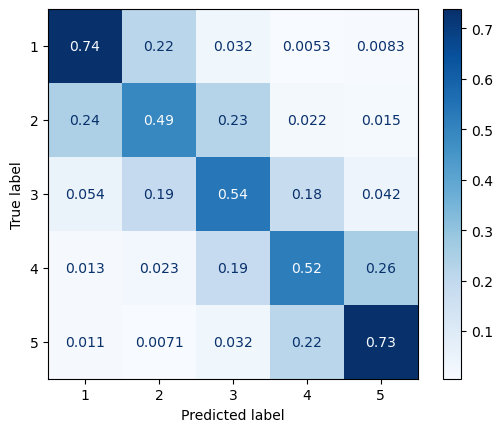


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


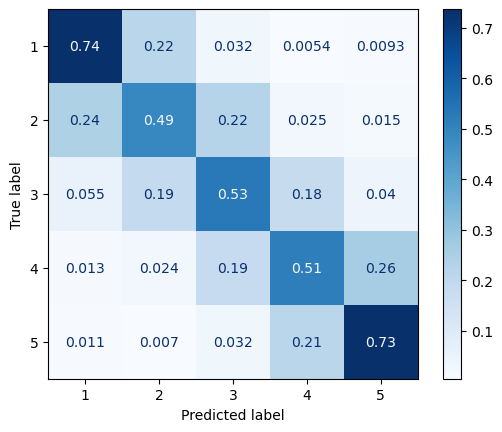

In [50]:
evaluate_model(clf_lr, model_name="lr_count_int")

#### Test for TfidfVectorizer (Binary)

In [51]:
X_train[:10,:]

<10x1506280 sparse matrix of type '<class 'numpy.float64'>'
	with 706 stored elements in Compressed Sparse Row format>

In [52]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [53]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.5min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


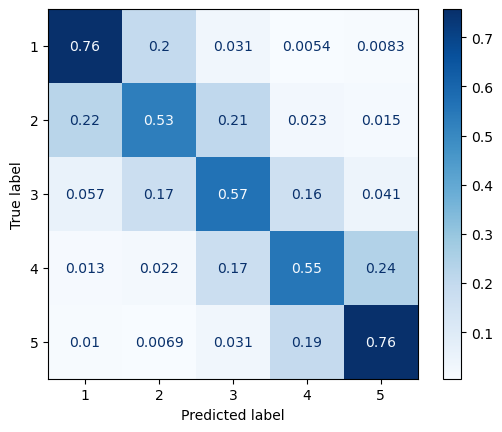


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


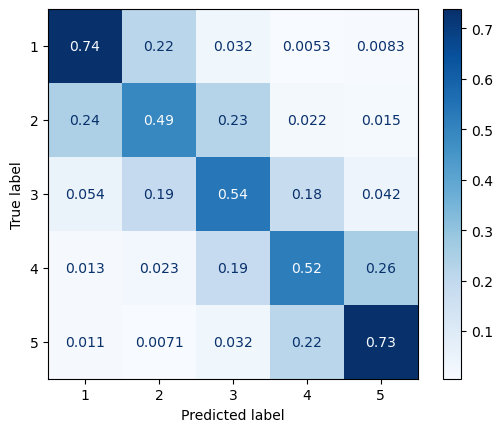


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


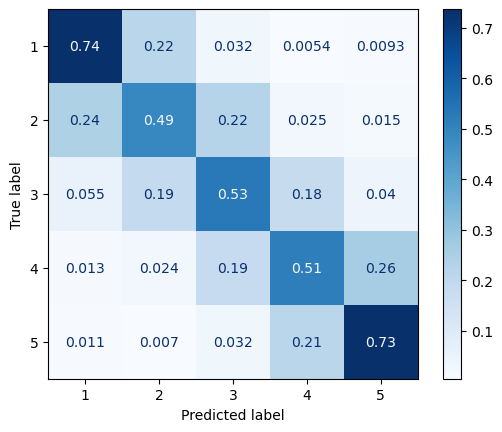

In [54]:
evaluate_model(clf_lr, model_name="lr_tfidf_bin")

#### Test for TfidfVectorizer (Integer)

In [55]:
X_train[:10,:]

<10x1506280 sparse matrix of type '<class 'numpy.float64'>'
	with 706 stored elements in Compressed Sparse Row format>

In [56]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [57]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.6min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


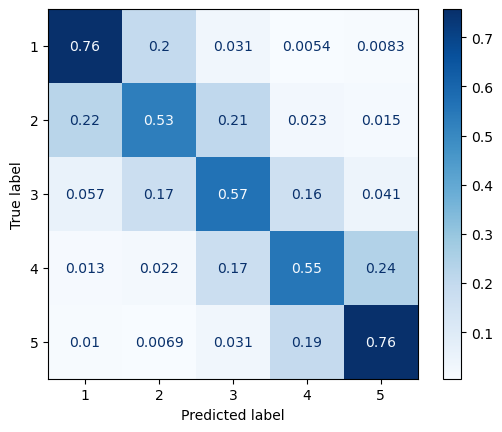


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


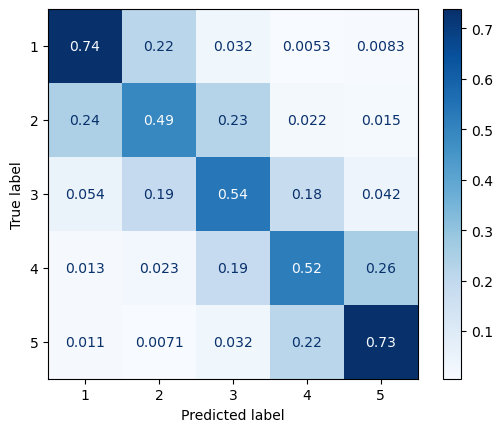


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


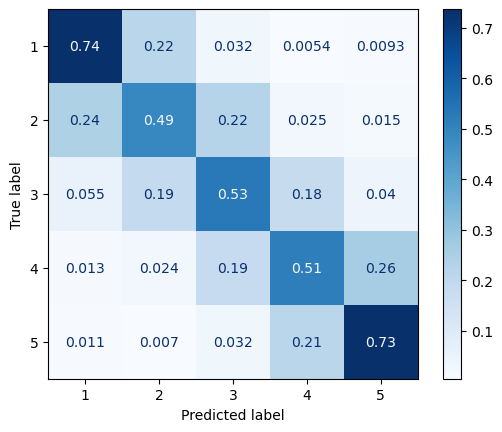

In [58]:
evaluate_model(clf_lr, model_name="lr_tfidf_int")

## Experiments and Results

We will use machine learning models and transformer-based models.

### Machine Learning

Navie Bayes, Logistic Regression, Random Forest, and Linear SVM will used in this section.

#### Evaluation Metrics

* Precision, recall, F1 score
* Accuracy
* Confusion matrix

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [5]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [6]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

#### Naive Bayes

In [59]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [60]:
%time clf_nb.fit(X_train, y_train)

Wall time: 1.91 s


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7389432

              precision    recall  f1-score   support

           1     0.7272    0.7996    0.7616    250000
           2     0.6875    0.6486    0.6675    250000
           3     0.7276    0.6703    0.6978    250000
           4     0.7276    0.7435    0.7354    250000
           5     0.8214    0.8328    0.8270    250000

    accuracy                         0.7389   1250000
   macro avg     0.7382    0.7389    0.7379   1250000
weighted avg     0.7382    0.7389    0.7379   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


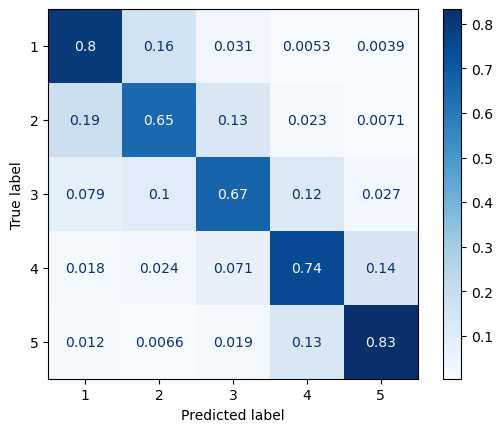


Validation Set
Accuracy: 0.622804

              precision    recall  f1-score   support

           1     0.6693    0.7209    0.6941     30214
           2     0.3933    0.4651    0.4262     21352
           3     0.4285    0.4787    0.4522     28532
           4     0.4930    0.5540    0.5217     60044
           5     0.8299    0.7015    0.7603    109858

    accuracy                         0.6228    250000
   macro avg     0.5628    0.5840    0.5709    250000
weighted avg     0.6465    0.6228    0.6313    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


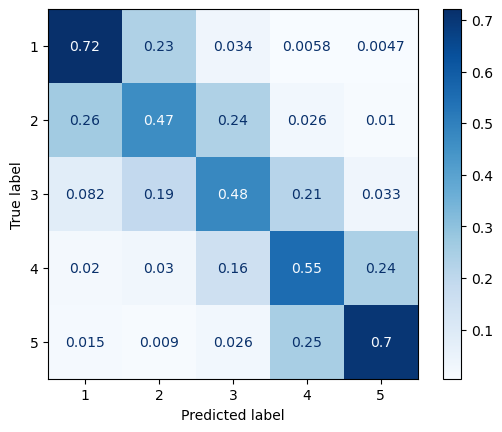


Testing Set
Accuracy: 0.62276

              precision    recall  f1-score   support

           1     0.6685    0.7187    0.6927     30269
           2     0.3942    0.4662    0.4272     21598
           3     0.4320    0.4751    0.4525     28770
           4     0.4898    0.5545    0.5202     59652
           5     0.8316    0.7029    0.7619    109711

    accuracy                         0.6228    250000
   macro avg     0.5632    0.5835    0.5709    250000
weighted avg     0.6465    0.6228    0.6313    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


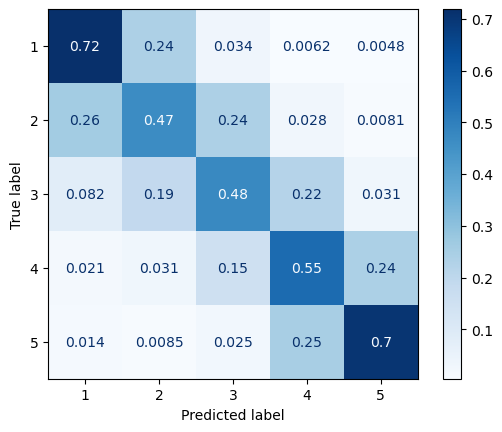

In [61]:
evaluate_model(clf_nb, model_name="nb")

In [62]:
del clf_nb

#### Logisitc Regression Classifier

In [63]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [64]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.6min finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

Training Set
Accuracy: 0.6322992

              precision    recall  f1-score   support

           1     0.7125    0.7563    0.7337    250000
           2     0.5693    0.5303    0.5491    250000
           3     0.5612    0.5656    0.5634    250000
           4     0.5884    0.5519    0.5696    250000
           5     0.7138    0.7573    0.7349    250000

    accuracy                         0.6323   1250000
   macro avg     0.6290    0.6323    0.6301   1250000
weighted avg     0.6290    0.6323    0.6301   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


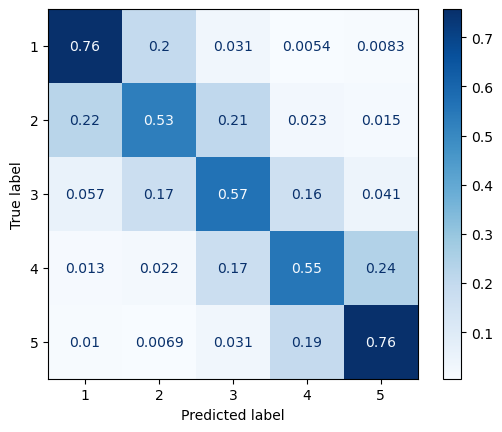


Validation Set
Accuracy: 0.639664

              precision    recall  f1-score   support

           1     0.7184    0.7383    0.7282     30214
           2     0.4266    0.4932    0.4575     21352
           3     0.4272    0.5360    0.4755     28532
           4     0.5149    0.5181    0.5165     60044
           5     0.8229    0.7344    0.7761    109858

    accuracy                         0.6397    250000
   macro avg     0.5820    0.6040    0.5907    250000
weighted avg     0.6573    0.6397    0.6464    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


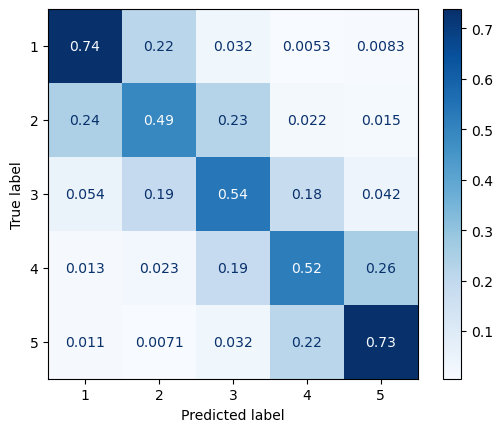


Testing Set
Accuracy: 0.637912

              precision    recall  f1-score   support

           1     0.7172    0.7371    0.7270     30269
           2     0.4272    0.4927    0.4576     21598
           3     0.4263    0.5290    0.4721     28770
           4     0.5092    0.5142    0.5117     59652
           5     0.8225    0.7350    0.7763    109711

    accuracy                         0.6379    250000
   macro avg     0.5805    0.6016    0.5889    250000
weighted avg     0.6552    0.6379    0.6446    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


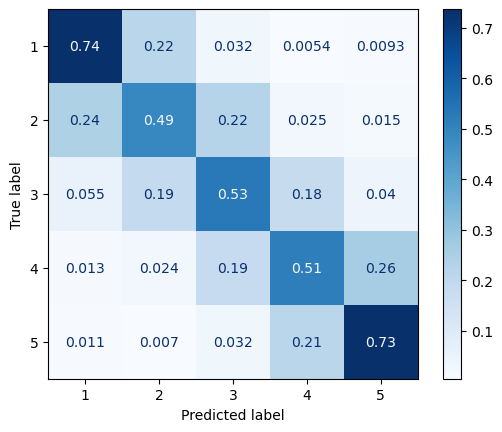

In [65]:
evaluate_model(clf_lr, model_name="lr")

In [66]:
del clf_lr

#### Random Forest Classifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [68]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.1min finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=0, verbose=1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   24.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  6.1min finished


Training Set
Accuracy: 0.5924112

              precision    recall  f1-score   support

           1     0.6010    0.8402    0.7008    250000
           2     0.5871    0.4308    0.4970    250000
           3     0.5967    0.4522    0.5145    250000
           4     0.5695    0.4566    0.5068    250000
           5     0.5977    0.7822    0.6776    250000

    accuracy                         0.5924   1250000
   macro avg     0.5904    0.5924    0.5793   1250000
weighted avg     0.5904    0.5924    0.5793   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   25.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  6.2min finished


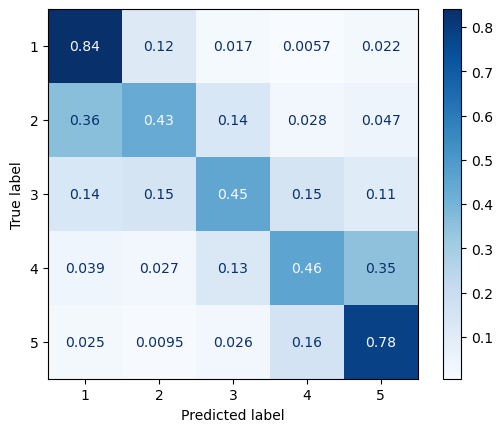

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   24.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   58.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  1.1min finished


Validation Set
Accuracy: 0.609356

              precision    recall  f1-score   support

           1     0.5868    0.8252    0.6859     30214
           2     0.4008    0.3746    0.3873     21352
           3     0.4124    0.4012    0.4067     28532
           4     0.4961    0.4061    0.4466     60044
           5     0.7554    0.7607    0.7581    109858

    accuracy                         0.6094    250000
   macro avg     0.5303    0.5536    0.5369    250000
weighted avg     0.6033    0.6094    0.6028    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   24.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   56.6s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  1.1min finished


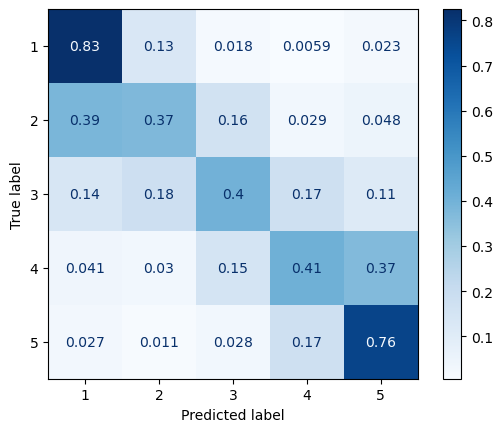

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   23.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   54.9s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  1.1min finished


Testing Set
Accuracy: 0.607676

              precision    recall  f1-score   support

           1     0.5849    0.8181    0.6821     30269
           2     0.4039    0.3765    0.3897     21598
           3     0.4138    0.3957    0.4046     28770
           4     0.4904    0.4027    0.4422     59652
           5     0.7531    0.7622    0.7576    109711

    accuracy                         0.6077    250000
   macro avg     0.5292    0.5510    0.5352    250000
weighted avg     0.6008    0.6077    0.6008    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   23.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   55.7s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:  1.1min finished


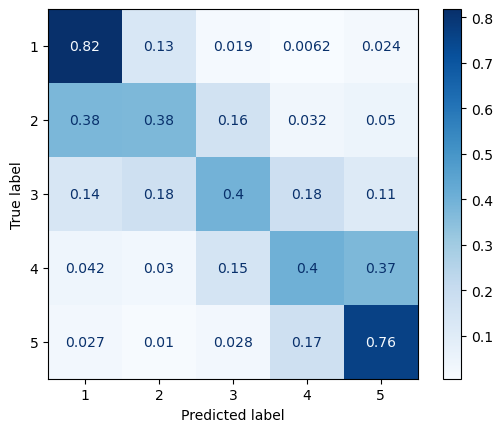

In [69]:
evaluate_model(clf_rf, model_name="rf")

In [70]:
del clf_rf

#### Linear Support Vector Machine (SVM)

In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [72]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 0.11, NNZs: 1492948, Bias: 0.002069, T: 1125000, Avg. loss: 0.440904
Total training time: 2.49 seconds.
Norm: 0.10, NNZs: 1492616, Bias: -0.006094, T: 1125000, Avg. loss: 0.494533
Total training time: 2.39 seconds.
Norm: 0.11, NNZs: 1483209, Bias: 0.001804, T: 1125000, Avg. loss: 0.442281
Total training time: 2.35 seconds.
Norm: 0.10, NNZs: 1499711, Bias: -0.005621, T: 1125000, Avg. loss: 0.508756
Total training time: 2.48 seconds.
Norm: 0.11, NNZs: 1500354, Bias: -0.006380, T: 1125000, Avg. loss: 0.503462
Total training time: 2.43 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.10, NNZs: 1501806, Bias: -0.006484, T: 2250000, Avg. loss: 0.481108
Total training time: 4.79 seconds.
Norm: 0.10, NNZs: 1495424, Bias: -0.006191, T: 2250000, Avg. loss: 0.473787
Total training time: 4.77 seconds.
Norm: 0.11, NNZs: 1495724, Bias: 0.001973, T: 2250000, Avg. loss: 0.420576
Total training time: 4.94 seconds.
Norm:

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.7559888

              precision    recall  f1-score   support

           1     0.6497    0.9341    0.7664    250000
           2     0.8296    0.5945    0.6926    250000
           3     0.8623    0.6243    0.7242    250000
           4     0.8026    0.6972    0.7462    250000
           5     0.7421    0.9299    0.8255    250000

    accuracy                         0.7560   1250000
   macro avg     0.7773    0.7560    0.7510   1250000
weighted avg     0.7773    0.7560    0.7510   1250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


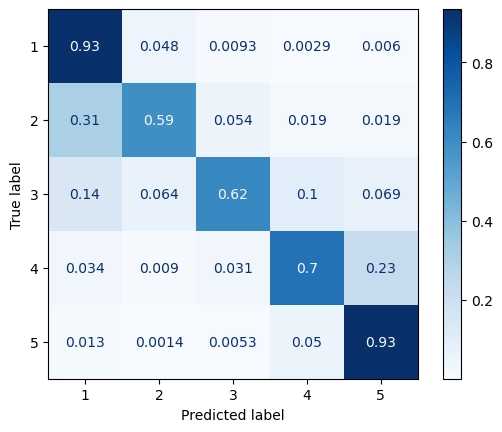


Validation Set
Accuracy: 0.631924

              precision    recall  f1-score   support

           1     0.5596    0.8583    0.6775     30214
           2     0.4250    0.3321    0.3728     21352
           3     0.4781    0.3340    0.3933     28532
           4     0.5273    0.4248    0.4705     60044
           5     0.7578    0.8185    0.7870    109858

    accuracy                         0.6319    250000
   macro avg     0.5495    0.5535    0.5402    250000
weighted avg     0.6181    0.6319    0.6174    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


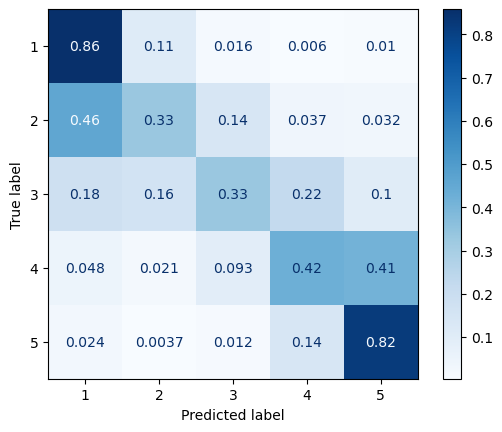


Testing Set
Accuracy: 0.630884

              precision    recall  f1-score   support

           1     0.5583    0.8534    0.6750     30269
           2     0.4272    0.3367    0.3766     21598
           3     0.4787    0.3322    0.3922     28770
           4     0.5223    0.4200    0.4656     59652
           5     0.7578    0.8204    0.7879    109711

    accuracy                         0.6309    250000
   macro avg     0.5489    0.5525    0.5394    250000
weighted avg     0.6168    0.6309    0.6162    250000



C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


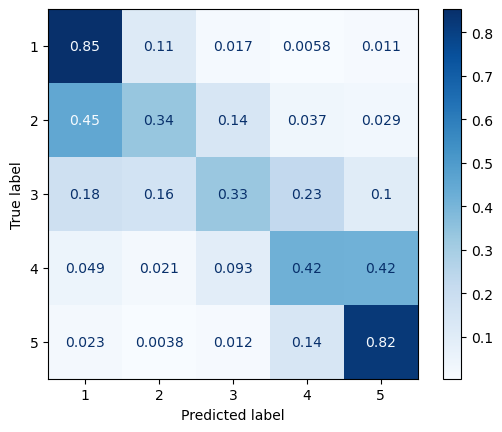

In [73]:
evaluate_model(clf_sgd, model_name="sgd")

10: 0.611916

20: 0.616532

30: 0.617348

35: 0.617388

40: 0.616676

In [74]:
del clf_sgd

### Deep Learning

Transformer-based models including BERT, DistilBERT, RoBERTa, and XLNet will be used in this section.

#### Packages

The Python package `simpletransformers` will be used.

In [37]:
%pip install simpletransformers
from simpletransformers.classification import ClassificationModel

C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Evaluation Metrics

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [77]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
  y = df['labels'].tolist()
  y_pred, raw_outputs = model.predict(df['text'].tolist())

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'), 
                       range(1,6), range(1,6))
  plt.figure(figsize=(6,4))
  ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [78]:
def evaluate_bert_model(model, model_name="model"):
  evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
  evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
  # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

#### BERT

BERT (Bidirectional Encoder Representations)

##### Tests for Maximum Sequence Level

In [46]:
import torch
cuda_available = torch.cuda.is_available()

In [50]:
model_bert_base_cased_64 = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    use_cuda=True,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
model_bert_base_cased_64.train_model(df_train)

  0%|          | 399/1250000 [00:56<43:37:08,  7.96it/s]

In [ ]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")

In [ ]:
del model_bert_base_cased_64

##### Uncased BERT

In [ ]:
model_bert_base_uncased = \
ClassificationModel('bert',
                    'bert-base-uncased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_bert_base_uncased.train_model(df_train, eval_df=df_dev)

In [ ]:
model_bert_base_uncased = \
ClassificationModel('bert',
                    'outputs_bert_base_uncased/',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
evaluate_bert_model(model_bert_base_uncased, model_name="bert_base_uncased")

In [ ]:
del model_bert_base_uncased

##### Cased BERT

In [42]:
model_bert_base_cased = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased/",
                          "best_model_dir": "outputs_bert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [39]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=1, overwrite_output_dir=True, manual_seed=42, silent=True)

model = ClassificationModel(model_type='roberta', model_name='roberta-base', use_cuda=True, num_labels=2, 
                            args=model_args)

Downloading: 100%|██████████| 481/481 [00:00<00:00, 498kB/s]
C:\Users\HP WORLD ANAND\anaconda3\envs\gpu\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP WORLD ANAND\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 501M/501M [01:15<00:00, 6.61MB/

In [41]:
model.train_model(df_train)

KeyboardInterrupt: 

In [ ]:
model_bert_base_cased.train_model(df_train)

  0%|          | 466/1250000 [01:13<66:15:53,  5.24it/s]

In [ ]:
evaluate_bert_model(model_bert_base_cased, model_name="bert_base_cased")

In [ ]:
del model_bert_base_cased

##### Cased Large BERT

In [ ]:
model_bert_large_cased = \
ClassificationModel('bert',
                    'bert-large-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_large_cased/",
                          "best_model_dir": "outputs_bert_large_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [ ]:
model_bert_large_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8128059037542343)


Validation Set
Accuracy: 0.699168

              precision    recall  f1-score   support

           0     0.7985    0.7782    0.7882     31118
           1     0.5111    0.6072    0.5550     22851
           2     0.5550    0.6029    0.5780     31401
           3     0.5916    0.6107    0.6010     62178
           4     0.8469    0.7788    0.8114    102452

    accuracy                         0.6992    250000
   macro avg     0.6606    0.6756    0.6667    250000
weighted avg     0.7100    0.6992    0.7034    250000



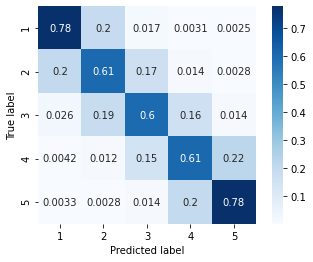


Testing Set
Accuracy: 0.700408

              precision    recall  f1-score   support

           0     0.8068    0.7799    0.7931     31175
           1     0.5136    0.6130    0.5589     22635
           2     0.5523    0.6039    0.5769     30996
           3     0.5889    0.6115    0.6000     62024
           4     0.8489    0.7780    0.8119    103170

    accuracy                         0.7004    250000
   macro avg     0.6621    0.6773    0.6682    250000
weighted avg     0.7120    0.7004    0.7050    250000



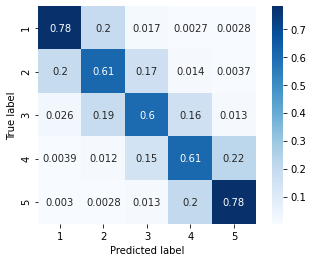

In [ ]:
evaluate_bert_model(model_bert_large_cased, model_name="bert_large_cased")

In [ ]:
del model_bert_large_cased

#### DistilBERT 

##### Uncased DistilBERT

In [ ]:
model_distilbert_base_uncased = \
ClassificationModel('distilbert', 
                    'distilbert-base-uncased', 
                    num_labels=5,
                    args={"output_dir": "outputs_distilbert_base_uncased/",
                          "best_model_dir": "outputs_distilbert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
model_distilbert_base_uncased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8415822796463013)


Validation Set
Accuracy: 0.68422

              precision    recall  f1-score   support

           0     0.7881    0.7575    0.7725     31118
           1     0.4878    0.6017    0.5388     22851
           2     0.5389    0.5773    0.5574     31401
           3     0.5759    0.5950    0.5853     62178
           4     0.8360    0.7673    0.8002    102452

    accuracy                         0.6842    250000
   macro avg     0.6454    0.6598    0.6508    250000
weighted avg     0.6962    0.6842    0.6889    250000



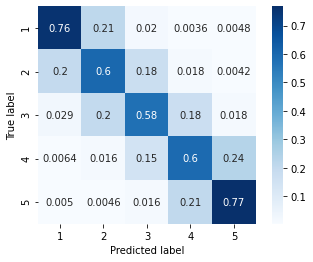


Testing Set
Accuracy: 0.68466

              precision    recall  f1-score   support

           0     0.7951    0.7568    0.7755     31175
           1     0.4888    0.6051    0.5408     22635
           2     0.5340    0.5760    0.5542     30996
           3     0.5726    0.5956    0.5839     62024
           4     0.8381    0.7665    0.8007    103170

    accuracy                         0.6847    250000
   macro avg     0.6457    0.6600    0.6510    250000
weighted avg     0.6975    0.6847    0.6897    250000



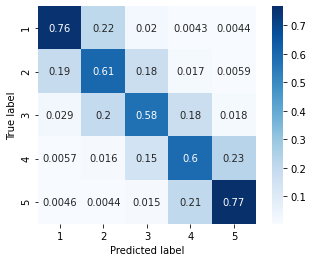

In [ ]:
evaluate_bert_model(model_distilbert_base_uncased, model_name="distilbert_base_uncased")

In [ ]:
del model_distilbert_base_uncased

##### Cased DistilBERT

In [ ]:
model_distilbert_base_cased = \
ClassificationModel('distilbert',
                    'distilbert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_distilbert_base_cased/",
                          "best_model_dir": "outputs_bert_distilbert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
model_distilbert_base_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8240574915271759)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b97525550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b97525550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Validation Set
Accuracy: 0.693548

              precision    recall  f1-score   support

           0     0.7911    0.7779    0.7845     31118
           1     0.5015    0.5952    0.5444     22851
           2     0.5496    0.5836    0.5661     31401
           3     0.5868    0.5982    0.5924     62178
           4     0.8378    0.7814    0.8087    102452

    accuracy                         0.6935    250000
   macro avg     0.6534    0.6673    0.6592    250000
weighted avg     0.7026    0.6935    0.6972    250000



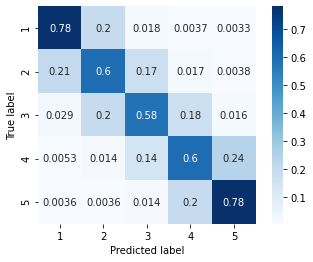


Testing Set
Accuracy: 0.694388

              precision    recall  f1-score   support

           0     0.7976    0.7749    0.7861     31175
           1     0.5027    0.5977    0.5461     22635
           2     0.5416    0.5838    0.5619     30996
           3     0.5854    0.5995    0.5924     62024
           4     0.8411    0.7815    0.8102    103170

    accuracy                         0.6944    250000
   macro avg     0.6537    0.6675    0.6593    250000
weighted avg     0.7045    0.6944    0.6985    250000



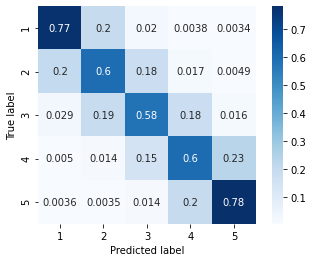

In [ ]:
evaluate_bert_model(model_distilbert_base_cased, model_name="distilbert_base_cased")

In [ ]:
del model_distilbert_base_cased

#### RoBERTa

In [36]:
model_roberta_base = \
ClassificationModel('roberta', 
                    'roberta-base', 
                    num_labels=5,
                    use_cuda=True,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

NameError: name 'ClassificationModel' is not defined

In [ ]:
model_roberta_base.train_model(df_train)


Validation Set
Accuracy: 0.701536

              precision    recall  f1-score   support

           0     0.8036    0.7844    0.7939     31118
           1     0.5135    0.6090    0.5572     22851
           2     0.5615    0.6082    0.5839     31401
           3     0.5911    0.6235    0.6069     62178
           4     0.8522    0.7730    0.8106    102452

    accuracy                         0.7015    250000
   macro avg     0.6644    0.6796    0.6705    250000
weighted avg     0.7137    0.7015    0.7062    250000



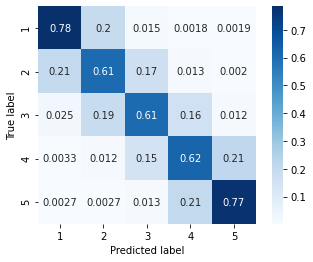


Testing Set
Accuracy: 0.702916

              precision    recall  f1-score   support

           0     0.8119    0.7818    0.7966     31175
           1     0.5143    0.6156    0.5604     22635
           2     0.5577    0.6062    0.5809     30996
           3     0.5900    0.6273    0.6081     62024
           4     0.8550    0.7727    0.8118    103170

    accuracy                         0.7029    250000
   macro avg     0.6658    0.6807    0.6716    250000
weighted avg     0.7162    0.7029    0.7080    250000



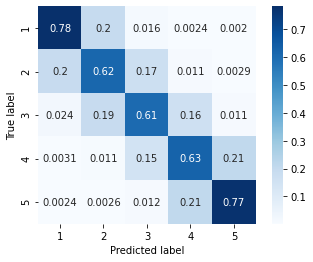

In [ ]:
evaluate_bert_model(model_roberta_base, model_name="roberta_base")

In [ ]:
del model_roberta_base

#### XLNet

In [ ]:
model_xlnet_base_cased = \
ClassificationModel('xlnet', 
                    'xlnet-base-cased', 
                    num_labels=5,
                    args={"output_dir": "outputs_xlnet_base_cased/",
                          "best_model_dir": "outputs_xlnet_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model_xlnet_base_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.7971919678201675)


Validation Set
Accuracy: 0.703548

              precision    recall  f1-score   support

           0     0.8015    0.7842    0.7928     31118
           1     0.5201    0.5948    0.5549     22851
           2     0.5595    0.6224    0.5893     31401
           3     0.5976    0.6123    0.6049     62178
           4     0.8470    0.7836    0.8140    102452

    accuracy                         0.7035    250000
   macro avg     0.6651    0.6795    0.6712    250000
weighted avg     0.7133    0.7035    0.7074    250000



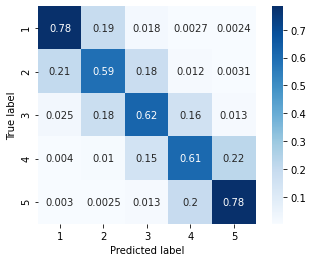


Testing Set
Accuracy: 0.704404

              precision    recall  f1-score   support

           0     0.8097    0.7816    0.7954     31175
           1     0.5231    0.6012    0.5594     22635
           2     0.5558    0.6228    0.5874     30996
           3     0.5943    0.6146    0.6043     62024
           4     0.8494    0.7822    0.8144    103170

    accuracy                         0.7044    250000
   macro avg     0.6664    0.6805    0.6722    250000
weighted avg     0.7152    0.7044    0.7087    250000



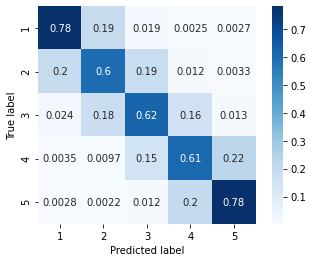

In [ ]:
evaluate_bert_model(model_xlnet_base_cased, model_name="xlnet_base_cased")

In [ ]:
del model_xlnet_base_cased

## Conclusions

In this project, Yelp review ratings are predicted through machine learning and transformer-based models.